In [1]:
import kagglehub

# Download latest version to a specific path
# The `path` argument in dataset_download specifies a file within the dataset, not the download location.
# Removing the path argument will download the dataset to the default location.
path = kagglehub.dataset_download("kaustubhdikshit/neu-surface-defect-database")

# The error message suggested accessing the files at this location after download.
dataset_files_path = "/kaggle/input/neu-surface-defect-database"

print("Path to dataset files:", dataset_files_path)

Path to dataset files: /kaggle/input/neu-surface-defect-database


In [2]:
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np


Defect types found: ['inclusion', 'scratches', 'pitted_surface', 'patches', 'crazing', 'rolled-in_scale']


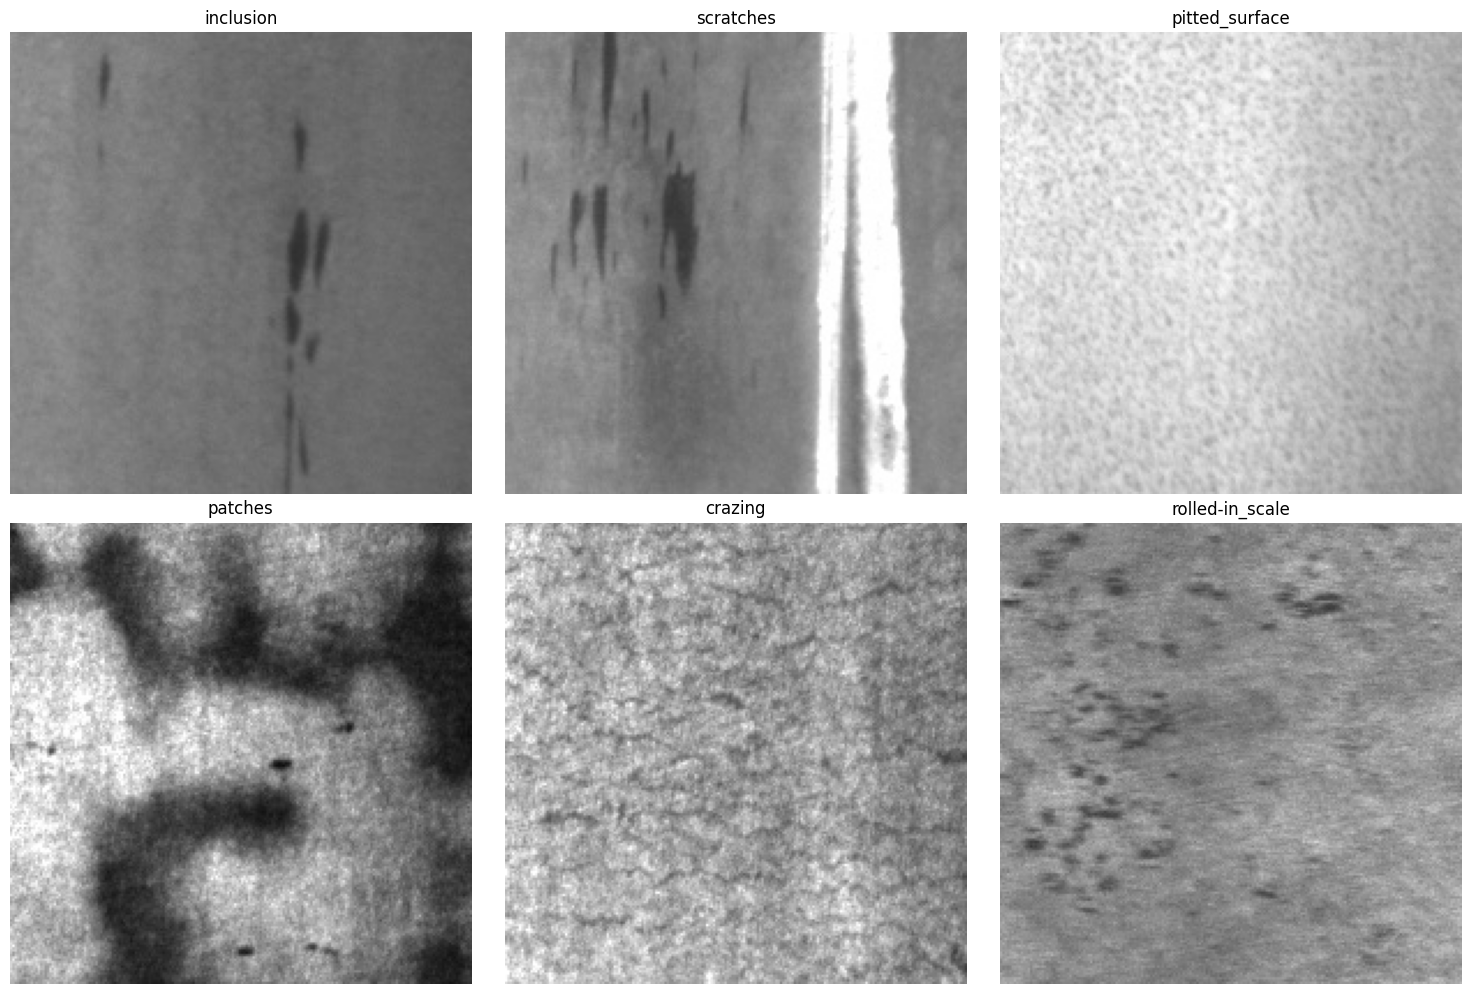

In [3]:
# Exploration
from PIL import Image
import os
import matplotlib.pyplot as plt

# Assuming the dataset is structured with subdirectories for each defect type within NEU-DET/train/images
dataset_root = "/kaggle/input/neu-surface-defect-database/NEU-DET/train/images/"

# Get the list of defect types (subdirectories)
defect_types = [d for d in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, d))]

print("Defect types found:", defect_types)

# Display one image from each defect type
plt.figure(figsize=(15, 10))
for i, defect_type in enumerate(defect_types):
    defect_dir = os.path.join(dataset_root, defect_type)
    # Get a list of image files in the directory (assuming .jpg extension)
    image_files = [f for f in os.listdir(defect_dir) if f.endswith('.jpg')]

    if image_files:
        # Pick the first image file
        image_path = os.path.join(defect_dir, image_files[0])
        try:
            img = Image.open(image_path)
            plt.subplot(2, 3, i + 1) # Adjust subplot grid based on number of defect types
            plt.imshow(img)
            plt.title(defect_type)
            plt.axis('off')
        except Exception as e:
            print(f"Could not open image {image_path}: {e}")
    else:
        print(f"No .jpg images found in {defect_dir}")

plt.tight_layout()
plt.show()

In [4]:
#preprocessing
# Define the target image size
img_height = 75 # Use img_size as defined in the model cell
img_width = 75 # Use img_size as defined in the model cell

# Define the paths to your training and validation image directories
train_dataset_root = "/kaggle/input/neu-surface-defect-database/NEU-DET/train/images/"
validation_dataset_root = "/kaggle/input/neu-surface-defect-database/NEU-DET/validation/images/" # Assuming a 'valid' directory for validation

# Define a preprocessing function
def preprocess(image, label):
    # Normalize pixel values from [0, 255] to [0, 1]
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

# Create datasets from the image files for training and validation
# This assumes your directory structure is defect_type/image.jpg within train/images and valid/images
# Labels will be inferred from the directory structure
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dataset_root,
    labels='inferred', # Infer labels from directory structure
    label_mode='categorical', # Use categorical labels for classification
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=32, # Define batch size
    shuffle=True # Shuffle training data
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dataset_root,
    labels='inferred', # Infer labels from directory structure
    label_mode='categorical', # Use categorical labels for classification
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=32, # Define batch size
    shuffle=False # No need to shuffle validation data
)


# Apply the preprocessing function to the datasets
train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

# Add data augmentation to the training dataset
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))


print("Training dataset element spec:", train_dataset.element_spec)
print("Validation dataset element spec:", validation_dataset.element_spec)

# Optional: Prefetch data for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("\nData preparation complete. Training and validation datasets are ready.")

Found 1440 files belonging to 6 classes.
Found 360 files belonging to 6 classes.
Training dataset element spec: (TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))
Validation dataset element spec: (TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))

Data preparation complete. Training and validation datasets are ready.


In [5]:
#Transfer Learning Using Pre-trained CNN Models
from tensorflow.keras import applications, models, layers

img_size = 75
pre_trained_models = {
    "ResNet50": applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3)),
    # Removed VGG16 as requested
     "VGG16": applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3)),
}

results = {}

for model_name, base_model in pre_trained_models.items():
    # Freeze the base model
    base_model.trainable = False

    # Add custom classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    # Display the model architecture
    print(f"\nModel Architecture: {model_name}")
    model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

Model Architecture: ResNet50


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Model Architecture: VGG16


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
# Compile the models pre trained
from tensorflow.keras import applications, models, layers

img_size = 75
pre_trained_models = {
   "ResNet50": applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3)),
    # Removed VGG16 as requested
    "VGG19": applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3)),
}

results = {}

#compling the model
compiled_models = {}

for model_name, base_model in pre_trained_models.items():
    # Re-create the model with the custom head (in case the previous cell was not run recently)
    # This ensures we compile the model with the custom classification head
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Reduced dropout rate to 0.3
        tf.keras.layers.Dense(6, activation='softmax') # Assuming 6 classes based on previous output
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    compiled_models[model_name] = model

    print(f"\n{model_name} Model Compiled.")
    model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

ResNet50 Model Compiled.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,798 (91.99 MB)

 Trainable params: 24,060,678 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)


VGG19 Model Compiled.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 2, 2, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,157,254 (76.89 MB)

 Trainable params: 20,157,254 (76.89 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the compiled models
# Assuming compiled_models dictionary, train_dataset, and validation_dataset are available
from tensorflow.keras.callbacks import EarlyStopping

epochs = 10 # You can adjust the number of epochs

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)


history = {}

for model_name, model in compiled_models.items():
    print(f"\nTraining {model_name}...")
    # Train the model with EarlyStopping callback
    history[model_name] = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=validation_dataset,
        callbacks=[early_stopping] # Add the EarlyStopping callback
    )
    print(f"{model_name} Training Complete.")


Training ResNet50...
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9954 - loss: 0.0198 - val_accuracy: 0.6611 - val_loss: 9.2813
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9453 - loss: 0.3648 - val_accuracy: 0.1667 - val_loss: 1571322.5000
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7254 - loss: 1.3881 - val_accuracy: 0.1667 - val_loss: 719401.6875
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.8156 - loss: 0.5998 - val_accuracy: 0.1667 - val_loss: 33175.6641
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.8521 - loss: 0.5324 - val_accuracy: 0.1528 - val_loss: 452.4007
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.8969 - loss: 0.3485 - val_accuracy: 0.3917 - val_loss: 12.1888
ResNet50 Training Complete.

Training VGG19...
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.8885 - loss: 0.3331 - val_accuracy: 0.6694 - val_loss: 0.8739
Epoch 2/10
45/45 ━━━━━━

# Task
Fine-tune the VGG19 model by unfreezing some layers, compiling with a lower learning rate, and training with early stopping.

## Unfreeze layers

### Subtask:
Unfreeze some layers of the pre-trained base model.


**Reasoning**:
Access the VGG19 base model and unfreeze the last few layers for fine-tuning.



In [10]:
vgg19_model = compiled_models["VGG19"]
vgg19_base = vgg19_model.layers[0] # Access the base model which is the first layer

# Unfreeze a certain number of layers from the end of the base model
# A common strategy is to unfreeze the last convolutional blocks
# Let's unfreeze the last 4 layers (example, adjust as needed)
unfreeze_layers_count = 4
for layer in vgg19_base.layers[-unfreeze_layers_count:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Print the number of trainable layers in the base model
trainable_count = sum([1 for layer in vgg19_base.layers if layer.trainable])
print(f"Number of trainable layers in the VGG19 base model: {trainable_count}")

Number of trainable layers in the VGG19 base model: 22


## Compile the model

### Subtask:
Compile the model with a lower learning rate for fine-tuning.


**Reasoning**:
Compile the VGG19 model with a lower learning rate for fine-tuning as requested.



In [11]:
# Access the VGG19 model from the compiled_models dictionary
vgg19_model = compiled_models["VGG19"]

# Compile the VGG19 model with a lower learning rate
vgg19_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Print a confirmation message
print("VGG19 model compiled for fine-tuning with a lower learning rate.")

# Print the model summary to verify the trainable parameters
vgg19_model.summary()

VGG19 model compiled for fine-tuning with a lower learning rate.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 2, 2, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,157,254 (76.89 MB)

 Trainable params: 20,157,254 (76.89 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

### Subtask:
Train the fine-tuned model on the training data with early stopping.


**Reasoning**:
Train the fine-tuned VGG19 model with early stopping and store the training history.



In [12]:
epochs = 30 # Set the number of epochs for fine-tuning

# Train the fine-tuned VGG19 model
history_vgg19_finetune = vgg19_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping] # Use the early_stopping callback
)

print("\nFine-tuned VGG19 Model Training Complete.")

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 0.9153 - loss: 0.2689 - val_accuracy: 0.7139 - val_loss: 0.8321
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9407 - loss: 0.2099 - val_accuracy: 0.7306 - val_loss: 0.7906
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9378 - loss: 0.2064 - val_accuracy: 0.7222 - val_loss: 0.7972
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.9436 - loss: 0.1879 - val_accuracy: 0.7250 - val_loss: 0.7993
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9510 - loss: 0.1707 - val_accuracy: 0.7306 - val_loss: 0.8071
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9546 - loss: 0.1643 - val_accuracy: 0.7333 - val_loss: 0.8002
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9564 - loss: 0.1610 - val_accuracy: 0.7417 - val_loss: 0.7858
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9548 - loss: 0.1652 - val_accuracy:

## Evaluate the model

### Subtask:
Evaluate the performance of the fine-tuned model on the validation data.


**Reasoning**:
Evaluate the fine-tuned VGG19 model on the validation dataset and print the results.



In [13]:
# Evaluate the fine-tuned VGG19 model on the validation data
vgg19_finetune_evaluation = vgg19_model.evaluate(validation_dataset)

# Print the evaluation results
print("\nFine-tuned VGG19 Model Evaluation Results on Validation Data:")
print(f"  Loss: {vgg19_finetune_evaluation[0]:.4f}")
print(f"  Accuracy: {vgg19_finetune_evaluation[1]:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8064 - loss: 0.5675

Fine-tuned VGG19 Model Evaluation Results on Validation Data:
  Loss: 0.7858
  Accuracy: 0.7417


## Summary:

### Data Analysis Key Findings

*   Four layers of the pre-trained VGG19 base model were unfrozen for fine-tuning.
*   The VGG19 model was compiled using the Adam optimizer with a reduced learning rate of \$1e-5.
*   The fine-tuned VGG19 model was trained for 12 epochs, with early stopping triggered.
*   The fine-tuned VGG19 model achieved a validation accuracy of approximately 0.7417 and a validation loss of approximately 0.7858.

### Insights or Next Steps

*   Compare the performance of the fine-tuned VGG19 model to other models trained on the same dataset to assess the effectiveness of the fine-tuning process.
*   Further hyperparameter tuning, such as experimenting with the number of unfrozen layers, learning rate schedules, or different optimizers, could potentially improve the model's performance.
